### Question: does `model` returns `[0 prob, 1 prob]` before softmax?

In [32]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    TextClassificationPipeline,
)
from engine.data import prepare_data_for_fine_tuning, read_data
from engine.xai import FeatureAblationText

In [33]:
MODEL_ID = "roberta-base"
MODEL_PATH = "output/checkpoint-2025/model.safetensors"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [34]:
test = read_data("data/split_raw/test.tsv")
# print(test)
test_dataset = prepare_data_for_fine_tuning(test, tokenizer)

Fifty-six percent decline in overall crime. A 73 percent decline in motor-vehicle theft. A 67 percent decline in robbery. A 66 percent decline in murder. This is way beyond what happened in the nation during this period of time.	crime	rudy-giuliani	Attorney	New York	republican	9	11	10	7	3	New York, N.Y.
5122.json	mostly-true	In 1958, there were 16 states in this country that prohibited -- prohibited -- an African-American and a Caucasian from being married.	civil-rights,gays-and-lesbians,marriage	sheila-oliver	Assemblywoman	New Jersey	democrat	0	1	1	3	0	a news conference
11191.json	true	Says Donald Trump has changed his mind on abortion.	abortion	carly-fiorina		California	republican	5	5	4	3	2	the first Republican presidential debate
10315.json	mostly-true	It has been many years, if ever, since an inmate has completed his or her high school diploma while incarcerated in a state correctional facility for adults.	corrections-and-updates,criminal-justice,public-safety	lc-buster-evans	Assis

Map: 100%|██████████| 790/790 [00:00<00:00, 4591.66 examples/s]


In [35]:
import torch
def get_device():
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU.")
        return "cuda"
    else:
        print("CUDA not available. Using CPU.")
        return "cpu"

In [36]:
config = AutoConfig.from_pretrained(MODEL_ID)
device = get_device()
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH, config=config
)
model.eval()
pipeline = TextClassificationPipeline(
    model=model, tokenizer=tokenizer, top_k=2, device=device
)

CUDA not available. Using CPU.


In [37]:
%%capture
if(device == "cuda"):
    model.cuda()
else:
    model.cpu()

In [38]:
obs = test["text"].tolist()[579]
if(device == "cuda"):
    obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cuda()
else:
    obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cpu()

print(obs)
print(obs_pt)


Fifty-six percent decline in overall crime. A 73 percent decline in motor-vehicle theft. A 67 percent decline in robbery. A 66 percent decline in murder. This is way beyond what happened in the nation during this period of time.	crime	rudy-giuliani	Attorney	New York	republican	9	11	10	7	3	New York, N.Y.
5122.json	mostly-true	In 1958, there were 16 states in this country that prohibited -- prohibited -- an African-American and a Caucasian from being married.	civil-rights,gays-and-lesbians,marriage	sheila-oliver	Assemblywoman	New Jersey	democrat	0	1	1	3	0	a news conference
11191.json	true	Says Donald Trump has changed his mind on abortion.	abortion	carly-fiorina		California	republican	5	5	4	3	2	the first Republican presidential debate
10315.json	mostly-true	It has been many years, if ever, since an inmate has completed his or her high school diploma while incarcerated in a state correctional facility for adults.	corrections-and-updates,criminal-justice,public-safety	lc-buster-evans	Assis

In [39]:
def forward(obs):
    return model(obs).logits

In [40]:

attr = FeatureAblationText(forward)
print(attr)
exp = attr.get_attributions([obs_pt])
exp

KeyboardInterrupt: 

In [41]:
tokens = pipeline.tokenizer.convert_ids_to_tokens(obs_pt[0])
print(tokens)

['<s>', 'F', 'ifty', '-', 'six', 'Ġpercent', 'Ġdecline', 'Ġin', 'Ġoverall', 'Ġcrime', '.', 'ĠA', 'Ġ73', 'Ġpercent', 'Ġdecline', 'Ġin', 'Ġmotor', '-', 'veh', 'icle', 'Ġtheft', '.', 'ĠA', 'Ġ67', 'Ġpercent', 'Ġdecline', 'Ġin', 'Ġrobbery', '.', 'ĠA', 'Ġ66', 'Ġpercent', 'Ġdecline', 'Ġin', 'Ġmurder', '.', 'ĠThis', 'Ġis', 'Ġway', 'Ġbeyond', 'Ġwhat', 'Ġhappened', 'Ġin', 'Ġthe', 'Ġnation', 'Ġduring', 'Ġthis', 'Ġperiod', 'Ġof', 'Ġtime', '.', 'ĉ', 'crime', 'ĉ', 'r', 'ud', 'y', '-', 'gi', 'ul', 'iani', 'ĉ', 'Attorney', 'ĉ', 'New', 'ĠYork', 'ĉ', 'rep', 'ublic', 'an', 'ĉ', '9', 'ĉ', '11', 'ĉ', '10', 'ĉ', '7', 'ĉ', '3', 'ĉ', 'New', 'ĠYork', ',', 'ĠN', '.', 'Y', '.', 'č', 'Ċ', '5', '122', '.', 'json', 'ĉ', 'mostly', '-', 'true', 'ĉ', 'In', 'Ġ1958', ',', 'Ġthere', 'Ġwere', 'Ġ16', 'Ġstates', 'Ġin', 'Ġthis', 'Ġcountry', 'Ġthat', 'Ġprohibited', 'Ġ--', 'Ġprohibited', 'Ġ--', 'Ġan', 'ĠAfrican', '-', 'American', 'Ġand', 'Ġa', 'ĠCaucasian', 'Ġfrom', 'Ġbeing', 'Ġmarried', '.', 'ĉ', 'civil', '-', 'rights', ',', 

In [42]:
import spacy

NER = spacy.load("en_core_web_sm")

doc = NER(obs)

print("Entities in the text:")
for ent in doc.ents:
    print(f"{ent.text} ({ent.label_}) - {spacy.explain(ent.label_)}")

Entities in the text:
Fifty-six percent (PERCENT) - Percentage, including "%"
73 percent (PERCENT) - Percentage, including "%"
67 percent (PERCENT) - Percentage, including "%"
66 percent (PERCENT) - Percentage, including "%"
New York (GPE) - Countries, cities, states
republican (NORP) - Nationalities or religious or political groups
9	11	10	7	3 (TIME) - Times smaller than a day
New York (GPE) - Countries, cities, states
N.Y. (GPE) - Countries, cities, states
5122.json (CARDINAL) - Numerals that do not fall under another type
1958 (DATE) - Absolute or relative dates or periods
16 (CARDINAL) - Numerals that do not fall under another type
African-American (NORP) - Nationalities or religious or political groups
Caucasian (NORP) - Nationalities or religious or political groups
sheila-oliver (ORG) - Companies, agencies, institutions, etc.
Assemblywoman (GPE) - Countries, cities, states
New Jersey (GPE) - Countries, cities, states
democrat (NORP) - Nationalities or religious or political grou

In [43]:
print("\nTokens and Their NER Information: \n")

for token in doc:
    if token.ent_type_:
        print(f"Token: {token.text}, Entity Type: {token.ent_type_} ({spacy.explain(token.ent_type_)})")
    else:
        print(f"Token: {token.text}, Not part of any entity.")


Tokens and Their NER Information: 

Token: Fifty, Entity Type: PERCENT (Percentage, including "%")
Token: -, Entity Type: PERCENT (Percentage, including "%")
Token: six, Entity Type: PERCENT (Percentage, including "%")
Token: percent, Entity Type: PERCENT (Percentage, including "%")
Token: decline, Not part of any entity.
Token: in, Not part of any entity.
Token: overall, Not part of any entity.
Token: crime, Not part of any entity.
Token: ., Not part of any entity.
Token: A, Not part of any entity.
Token: 73, Entity Type: PERCENT (Percentage, including "%")
Token: percent, Entity Type: PERCENT (Percentage, including "%")
Token: decline, Not part of any entity.
Token: in, Not part of any entity.
Token: motor, Not part of any entity.
Token: -, Not part of any entity.
Token: vehicle, Not part of any entity.
Token: theft, Not part of any entity.
Token: ., Not part of any entity.
Token: A, Not part of any entity.
Token: 67, Entity Type: PERCENT (Percentage, including "%")
Token: percent, 

In [44]:
print(len(tokens))

tokens_clear = [s.replace("Ġ", "") for s in tokens]
tokens_clear = tokens_clear[1:len(tokens_clear)-1]
print(tokens_clear)

print(exp)
print(len(exp))

408
['F', 'ifty', '-', 'six', 'percent', 'decline', 'in', 'overall', 'crime', '.', 'A', '73', 'percent', 'decline', 'in', 'motor', '-', 'veh', 'icle', 'theft', '.', 'A', '67', 'percent', 'decline', 'in', 'robbery', '.', 'A', '66', 'percent', 'decline', 'in', 'murder', '.', 'This', 'is', 'way', 'beyond', 'what', 'happened', 'in', 'the', 'nation', 'during', 'this', 'period', 'of', 'time', '.', 'ĉ', 'crime', 'ĉ', 'r', 'ud', 'y', '-', 'gi', 'ul', 'iani', 'ĉ', 'Attorney', 'ĉ', 'New', 'York', 'ĉ', 'rep', 'ublic', 'an', 'ĉ', '9', 'ĉ', '11', 'ĉ', '10', 'ĉ', '7', 'ĉ', '3', 'ĉ', 'New', 'York', ',', 'N', '.', 'Y', '.', 'č', 'Ċ', '5', '122', '.', 'json', 'ĉ', 'mostly', '-', 'true', 'ĉ', 'In', '1958', ',', 'there', 'were', '16', 'states', 'in', 'this', 'country', 'that', 'prohibited', '--', 'prohibited', '--', 'an', 'African', '-', 'American', 'and', 'a', 'Caucasian', 'from', 'being', 'married', '.', 'ĉ', 'civil', '-', 'rights', ',', 'g', 'ays', '-', 'and', '-', 'les', 'bians', ',', 'marriage', 'ĉ'

In [45]:
from engine.tokens_aggregate import TokenAggregate

In [46]:
aggregate_list = TokenAggregate.generate_aggregate_list(doc,exp,tokens_clear,tokens)

IndexError: index 52 is out of bounds for dimension 2 with size 52

In [47]:
i = 0
for aggregate in aggregate_list:
    print(f"Agregate nr: {i}")
    print(aggregate)
    print("\n")
    i=i+1


Agregate nr: 0
Is spacy NER: ['PERCENT']
spacy token: ['Fifty']
Our model clean: ['F', 'ifty']
Our model dirty: ['F', 'ifty']
model exp: [4.9620866775512695e-06, 8.806586265563965e-06]



Agregate nr: 1
Is spacy NER: ['PERCENT']
spacy token: ['-']
Our model clean: ['-']
Our model dirty: ['-']
model exp: [3.859400749206543e-06]



Agregate nr: 2
Is spacy NER: ['PERCENT']
spacy token: ['six']
Our model clean: ['six']
Our model dirty: ['six']
model exp: [7.4356794357299805e-06]



Agregate nr: 3
Is spacy NER: ['PERCENT']
spacy token: ['percent']
Our model clean: ['percent']
Our model dirty: ['Ġpercent']
model exp: [1.068413257598877e-05]



Agregate nr: 4
Is spacy NER: ['']
spacy token: ['decline']
Our model clean: ['decline']
Our model dirty: ['Ġdecline']
model exp: [1.0982155799865723e-05]



Agregate nr: 5
Is spacy NER: ['']
spacy token: ['in']
Our model clean: ['in']
Our model dirty: ['Ġin']
model exp: [7.361173629760742e-06]



Agregate nr: 6
Is spacy NER: ['']
spacy token: ['overall

In [ ]:
from tqdm import tqdm
NER = spacy.load("en_core_web_sm")
all_aggregate = []
for i,obs in enumerate(test["text"].tolist()):
    if(device == "cuda"):
        obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cuda()
    else:
        obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cpu()
    attr = FeatureAblationText(forward)

    exp = attr.get_attributions([obs_pt])
    tokens = pipeline.tokenizer.convert_ids_to_tokens(obs_pt[0])


    doc = NER(obs)
    tokens_clear = [s.replace("Ġ", "") for s in tokens]
    tokens_clear = tokens_clear[1:len(tokens_clear)-1]
    spacy_token_to_our_tokens = TokenAggregate.generate_aggregate_list(doc,exp,tokens_clear,tokens)
    if spacy_token_to_our_tokens is not False:
        all_aggregate = all_aggregate+spacy_token_to_our_tokens
    else:
        print(i)
        print(obs)


Fifty-six percent decline in overall crime. A 73 percent decline in motor-vehicle theft. A 67 percent decline in robbery. A 66 percent decline in murder. This is way beyond what happened in the nation during this period of time.	crime	rudy-giuliani	Attorney	New York	republican	9	11	10	7	3	New York, N.Y.
5122.json	mostly-true	In 1958, there were 16 states in this country that prohibited -- prohibited -- an African-American and a Caucasian from being married.	civil-rights,gays-and-lesbians,marriage	sheila-oliver	Assemblywoman	New Jersey	democrat	0	1	1	3	0	a news conference
11191.json	true	Says Donald Trump has changed his mind on abortion.	abortion	carly-fiorina		California	republican	5	5	4	3	2	the first Republican presidential debate
10315.json	mostly-true	It has been many years, if ever, since an inmate has completed his or her high school diploma while incarcerated in a state correctional facility for adults.	corrections-and-updates,criminal-justice,public-safety	lc-buster-evans	Assis

In [ ]:
for aggregate in all_aggregate:
    if(len(aggregate.spacy_token)>1):
        print(aggregate)

<Axes: >

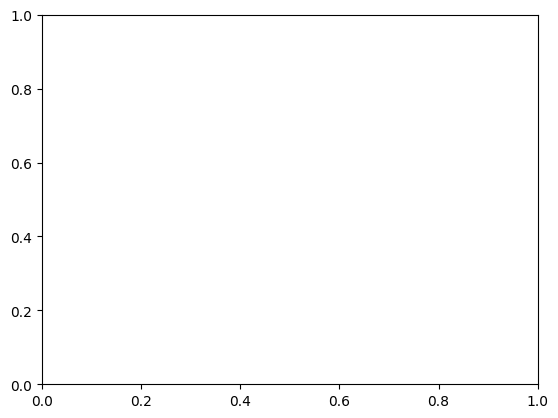

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

all_ner_types = set()

for aggregate in all_aggregate:
    for ner in aggregate.NERs:
        all_ner_types.add(ner)

exps = {}

for ner_type in all_ner_types:
    exps[ner_type] = []

for aggregate in all_aggregate:
    value = np.max(aggregate.model_exp)

    true_ners = [element for element in aggregate.NERs if element != '']
    if(len(true_ners)==0):
        exps[''].append(value)
    else:
        for ner in true_ners:
            exps[ner].append(value)


sns.boxplot(exps)

